In [1]:
import os
import numpy as np
import copy
import cv2 as cv
import json
import operator
import matplotlib.pyplot as plt

In [6]:
import import_ipynb
from image_processing_functions import read_image, canny_edge_response, adaptive_gaussian_threshold, \
    adaptive_mean_threshold, automatic_canny_edge_response, harris_corner_response, hough_line_detect_response, \
    hough_line_intersections, houghp_line_detect_response, houghp_line_points, corners_on_image, \
    furthest_points_on_image, crop_image, warp_image
# from hierarchical_clusterizations import cluster_lines, augment_cluster_lines, cluster_points, augment_cluster_points
# from kmeans_clusterizations import kmeans_cluster_lines, augment_kmcluster_lines, kmeans_cluster_points, augment_kmcluster_points

In [19]:
filename = '../datasets/dataset 1/data/0.jpg'
filename_2 = "../datasets/dataset 2/train/0028.png"

Loops: 1
Differences between distances: [ -42.32721   94.50391 -102.71582]
Crop because of distances: False
Distances between adjacent points [626.0, 581.0, 678.0, 576.0]
Crop because of points too close: False
Differences between distances: [ -42.32721   94.50391 -102.71582]
Distances between adjacent points [626.0, 581.0, 678.0, 576.0]
warp


{'img': array([[[ 85, 119, 155],
         [ 85, 119, 155],
         [ 84, 118, 154],
         ...,
         [144, 156, 174],
         [145, 158, 174],
         [145, 158, 174]],
 
        [[ 84, 118, 154],
         [ 83, 117, 153],
         [ 82, 116, 152],
         ...,
         [144, 156, 174],
         [145, 158, 174],
         [146, 159, 175]],
 
        [[ 82, 116, 152],
         [ 82, 116, 152],
         [ 80, 114, 150],
         ...,
         [145, 157, 175],
         [145, 158, 174],
         [146, 159, 175]],
 
        ...,
 
        [[ 52,  86, 122],
         [ 51,  87, 123],
         [ 54,  88, 124],
         ...,
         [ 47,  70, 108],
         [ 48,  71, 109],
         [ 51,  74, 112]],
 
        [[ 56,  92, 128],
         [ 56,  94, 129],
         [ 59,  95, 131],
         ...,
         [ 46,  69, 107],
         [ 48,  71, 109],
         [ 52,  75, 113]],
 
        [[ 61,  99, 134],
         [ 62, 100, 135],
         [ 64, 102, 137],
         ...,
         [ 45,  68, 1

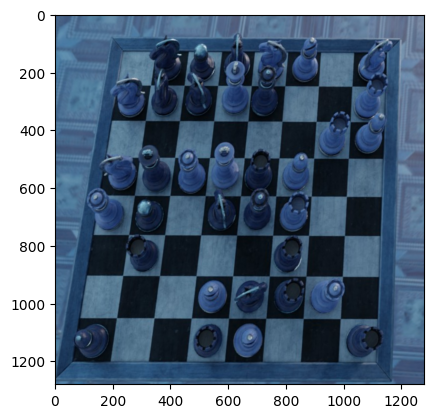

In [11]:
filename = '../datasets/dataset 1/data/1.jpg'

# this function checks if any of the detected points are not in the same distance range acceptable for perspective transformation
def check_distances(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_diffs = np.diff(corner_copy, axis=0)
    distances = np.sqrt(np.sum(corner_diffs**2, axis=1))
    print("Differences between distances:", np.diff(distances, axis=0))
    return np.any(np.diff(distances, axis=0) > 150) or np.any(np.diff(distances, axis=0) < -150)

# this function checks if the detected points are too close to each other
# here we find out if the distance of any two points that mark a line is shorter
def check_points(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_copy = np.array(corner_copy)
    point_distances = []
    for index in range(1, len(corner_copy)):
        point_distances.append(list(abs(corner_copy[index] - corner_copy[index-1]))[(index - 1) % 2])
    print("Distances between adjacent points", point_distances)
    return np.any(np.array(point_distances) < 150)

def localize_top_chessboard(img, corner_setup=10):
    global corners_found
    hl_threshold = 140
    canny_low_thr = 20
    canny_high_thr = 150
    cn_boost = 0
    nr_loops = 0
    ok = True

    # if any of the points appear near the ends of the image and the distances between them are almost the same, we move the threshold interval further
    try:
        while ok:
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr + cn_boost, high_thr=canny_high_thr + cn_boost)
            hough_lines = hough_line_detect_response(canny_filter, threshold=hl_threshold)
            hough_intersections = hough_line_intersections(hough_lines)
            corners_found = corners_on_image(hough_intersections)
            cn_boost += 10
            nr_loops += 1
            if np.all((0 < np.array(corners_found['list'])) & (np.array(corners_found['list']) < img.shape[0]) & (np.array(corners_found['list']) < img.shape[1])):
                if (np.any(np.array(corners_found['list']) < 100) or np.any(np.array(corners_found['list']) > img.shape[0] - 100) or np.any(np.array(corners_found['list']) > img.shape[1] - 100)) and check_distances(corners_found):
                    ok = True
                else:
                    ok = False
    except:
        print("Error encountered. Image cannot be processed anymore, now detecting corners for zooming it.")
        nr_loops = 20

    # we check if the distances between the detected corners are almost equal again
    # if it's true, it must be cropped, otherwise it can be warped, giving a much clearer perspective
    # in case the loop from above didn't manage to detect the corners, we will use the points that are the closest to the ends of image to zoom the board, using the initial threshold interval
    print("Loops:", nr_loops)
    print("Crop because of distances:", check_distances(corners_found))
    print("Crop because of points too close:", check_points(corners_found))
    if check_distances(corners_found) or check_points(corners_found):
        print("crop")
        image_op = crop_image
        if nr_loops >= 10:
            print("zoom")
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr)
            hough_lines = hough_line_detect_response(canny_filter, threshold=hl_threshold)
            hough_intersections = hough_line_intersections(hough_lines)
            hough_intersections['list'] = [values for values in hough_intersections['list'] if np.all(np.array(values) < img.shape[0] - 100) and np.all(np.array(values) < img.shape[1] - 100) and np.all(np.array(values) > 100)]
            corners_found = corners_on_image(hough_intersections)
    else:
        print("warp")
        image_op = warp_image

    # we move the found corners a bit to get all pieces fully visible
    corners_found = corners_found['list']
    corners_spaced = [[corners_found[0][0] - corner_setup, corners_found[0][1] - corner_setup], [corners_found[1][0] + corner_setup, corners_found[1][1] - corner_setup], corners_found[2], corners_found[3]]
    calibration = image_op(img, corners_spaced)

    localization_result = {
        'img' : img,
        'calibration': calibration,
        'corners' : corners_found,
        'process': image_op
    }
    return localization_result

localize_top_chessboard(read_image(filename), corner_setup=40)

Differences between distances: [  59.177856  350.08997  -454.112   ]
Differences between distances: [  58.991882  350.08997  -453.14154 ]
Loops: 3
Differences between distances: [ -42.051147   98.70117  -101.4942  ]
Crop because of distances: False
Distances between adjacent points [679.0, 641.0, 734.0, 627.0]
Crop because of points too close: False
Differences between distances: [ -42.051147   98.70117  -101.4942  ]
Distances between adjacent points [679.0, 641.0, 734.0, 627.0]
warp


{'img': array([[[102, 133, 166],
         [101, 132, 165],
         [ 99, 132, 165],
         ...,
         [ 46,  80, 116],
         [ 43,  79, 115],
         [ 43,  79, 115]],
 
        [[101, 132, 165],
         [101, 132, 165],
         [ 99, 132, 165],
         ...,
         [ 46,  80, 116],
         [ 43,  79, 115],
         [ 43,  79, 115]],
 
        [[100, 131, 164],
         [100, 131, 164],
         [ 97, 130, 163],
         ...,
         [ 46,  80, 116],
         [ 46,  80, 116],
         [ 45,  79, 115]],
 
        ...,
 
        [[ 93, 128, 162],
         [ 93, 128, 162],
         [ 94, 129, 163],
         ...,
         [ 52,  87, 127],
         [ 57,  89, 130],
         [ 59,  91, 132]],
 
        [[ 92, 127, 161],
         [ 92, 127, 161],
         [ 93, 128, 162],
         ...,
         [ 56,  91, 131],
         [ 61,  93, 134],
         [ 63,  95, 136]],
 
        [[ 91, 126, 160],
         [ 91, 126, 160],
         [ 93, 128, 162],
         ...,
         [ 59,  95, 1

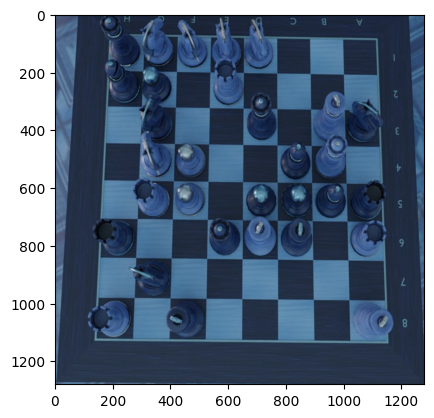

In [21]:
localize_top_chessboard(read_image('../datasets/dataset 1/data/0.jpg'), corner_setup=40)

Distances between adjacent points [ 11.83634045   9.72528306 -20.47828652]
Loops: 1
Distances between adjacent points [ 11.83634045   9.72528306 -20.47828652]
Crop because of distances: False
Differences between distances: [669, 682, 687, 666]
Crop because of points too close: False
Distances between adjacent points [ 11.83634045   9.72528306 -20.47828652]
Differences between distances: [669, 682, 687, 666]
warp


{'img': array([[[106, 130, 142],
         [106, 130, 142],
         [107, 131, 143],
         ...,
         [142, 148, 155],
         [141, 147, 154],
         [141, 147, 154]],
 
        [[106, 130, 142],
         [106, 130, 142],
         [107, 131, 143],
         ...,
         [142, 148, 155],
         [141, 147, 154],
         [141, 147, 154]],
 
        [[106, 130, 142],
         [107, 131, 143],
         [107, 131, 143],
         ...,
         [141, 147, 154],
         [141, 147, 154],
         [141, 147, 154]],
 
        ...,
 
        [[ 94, 120, 132],
         [ 94, 120, 132],
         [ 95, 121, 133],
         ...,
         [106, 130, 142],
         [106, 130, 142],
         [106, 130, 142]],
 
        [[ 93, 119, 131],
         [ 94, 120, 132],
         [ 94, 120, 132],
         ...,
         [105, 129, 141],
         [106, 130, 142],
         [106, 130, 142]],
 
        [[ 93, 119, 131],
         [ 93, 119, 131],
         [ 94, 120, 132],
         ...,
         [105, 129, 1

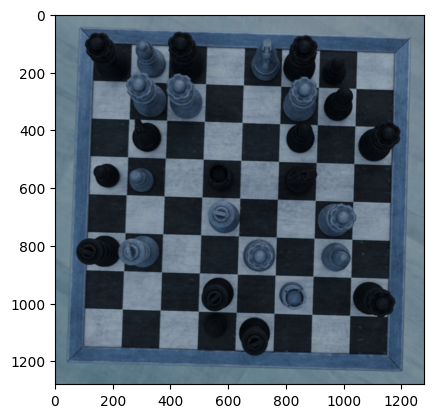

In [5]:
filename = '../datasets/dataset 1/data/10.jpg'

# this function checks if the detected points are too close to each other
# here we find out if the distance of any two points that mark a line is shorter
def check_points(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_copy = np.array(corner_copy)
    point_distances = []
    for index in range(1, len(corner_copy)):
        point_distances.append(list(abs(corner_copy[index] - corner_copy[index-1]))[(index - 1) % 2])
    print("Differences between distances:", point_distances)
    return np.any(np.array(point_distances) < 150)

# this function checks if any of the detected points are not in the same distance range acceptable for perspective transformation
def check_distances(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_diffs = np.diff(corner_copy, axis=0)
    distances = np.sqrt(np.sum(corner_diffs**2, axis=1))
    print("Distances between adjacent points", np.diff(distances, axis=0))
    return np.any(np.diff(distances, axis=0) > 150) or np.any(np.diff(distances, axis=0) < -150)

# checking if the corners can form a proper quadrilateral figure for detection
def check_point_angle(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_copy.append(corner_copy[1])
    angles = []
    for index in range(2, len(corner_copy)):
        A = np.array(corner_copy[index - 2])
        B = np.array(corner_copy[index - 1])
        C = np.array(corner_copy[index])
        dot_BA_BC = np.dot(A - B, C - B)
        angle = np.degrees(np.arccos(dot_BA_BC / (np.linalg.norm(A - B) * np.linalg.norm(C - B))))
        if 60 <= angle <= 80 or 100 <= angle <= 120:
            angles.append(angle)
    print(angles)
    return False if len(angles) >= 2 else True

def localize_top_chessboard_prob(img, corner_setup=10):
    global corners_found
    canny_low_thr = 20
    canny_high_thr = 150
    hlp_threshold = 90
    minLineLength = 100
    maxLineGap = 150
    cn_boost = 0
    hlp_lower = 0
    nr_loops = 0
    ok = True

    # if any of the points doesn't appear on the image, we move the threshold interval further
    try:
        while ok:
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr + cn_boost, high_thr=canny_high_thr + cn_boost)
            houghp_lines = houghp_line_detect_response(canny_filter, threshold=hlp_threshold - hlp_lower, minLineLength=minLineLength, maxLineGap=maxLineGap)
            for values in houghp_lines['list']:
                if np.any(np.array(values) > img.shape[0] - 100) or np.any(np.array(values) > img.shape[1] - 100) or np.any(np.array(values) < 100):
                    houghp_lines['list'].remove(values)
            houghp_points = houghp_line_points(houghp_lines)

            corners_found = corners_on_image(houghp_points)
            nr_loops += 1
            cn_boost += 10
            hlp_lower += 5
            if (np.any(np.array(corners_found['list']) < 100) or np.any(np.array(corners_found['list']) > img.shape[0] - 100) or np.any(np.array(corners_found['list']) > img.shape[1] - 100)) or check_distances(corners_found):
                ok = True
            else:
                ok = False
    except:
        print("Error encountered. Image cannot be processed anymore, now detecting corners for zooming it.")
        nr_loops = 20

    # we check if the distances between the detected corners are almost equal again
    # if it's true, it must be cropped, otherwise it can either be warped, giving a much clearer perspective, or the number of loops and the distance of the corners are checked
    # in case the loop from above didn't manage to detect the corners, hence the high number of loops, we will use the points that are the closest to the ends of image to zoom the board, using the initial threshold values
    print("Loops:", nr_loops)
    print("Crop because of distances:", check_distances(corners_found))
    print("Crop because of points too close:", check_points(corners_found))
    if check_distances(corners_found):
        print("crop")
        image_op = crop_image
    else:
        if nr_loops >= 10 or check_points(corners_found):
            print("zoom by cropping")
            hlp_threshold = 140
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr)
            houghp_lines = houghp_line_detect_response(canny_filter, threshold=hlp_threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
            for values in houghp_lines['list']:
                if np.any(np.array(values) > img.shape[0] - 100) or np.any(np.array(values) > img.shape[1] - 100) or np.any(np.array(values) < 100):
                    houghp_lines['list'].remove(values)
            houghp_points = houghp_line_points(houghp_lines)
            houghp_points['list'] = [values for values in houghp_points['list'] if np.all(np.array(values) < img.shape[0] - 100) and np.all(np.array(values) < img.shape[1] - 100) and np.all(np.array(values) > 100)]
            corners_found = corners_on_image(houghp_points)
            if check_distances(corners_found):
                print("checking angles, crop mode chosen")
                image_op = crop_image
                if check_point_angle(corners_found):
                    print("getting further points")
                    corners_found = furthest_points_on_image(houghp_points)
                    if check_distances(corners_found):
                        print("crop")
                        image_op = crop_image
                    else:
                        print("warp")
                        image_op = warp_image
            else:
                print("warp")
                image_op = warp_image
        else:
            print("warp")
            image_op = warp_image

    # we move the found corners a bit to get all pieces fully visible
    corners_found = corners_found['list']
    corners_spaced = [[corners_found[0][0] - corner_setup, corners_found[0][1] - corner_setup], [corners_found[1][0] + corner_setup, corners_found[1][1] - corner_setup], [corners_found[2][0] + corner_setup, corners_found[2][1] + corner_setup], [corners_found[3][0] - corner_setup, corners_found[3][1] + corner_setup]]
    calibration = image_op(img, corners_spaced)

    localization_result = {
        'img' : img,
        'calibration': calibration,
        'corners' : corners_found,
        'process': image_op
    }
    return localization_result

localize_top_chessboard_prob(read_image(filename), corner_setup=40)

Distances between adjacent points [ 28.77661477  33.88763099 -47.07979905]
Loops: 1
Distances between adjacent points [ 28.77661477  33.88763099 -47.07979905]
Crop because of distances: False
Differences between distances: [673, 705, 732, 680]
Crop because of points too close: False
Distances between adjacent points [ 28.77661477  33.88763099 -47.07979905]
Differences between distances: [673, 705, 732, 680]
warp


{'img': array([[[102, 133, 166],
         [101, 132, 165],
         [ 99, 132, 165],
         ...,
         [ 46,  80, 116],
         [ 43,  79, 115],
         [ 43,  79, 115]],
 
        [[101, 132, 165],
         [101, 132, 165],
         [ 99, 132, 165],
         ...,
         [ 46,  80, 116],
         [ 43,  79, 115],
         [ 43,  79, 115]],
 
        [[100, 131, 164],
         [100, 131, 164],
         [ 97, 130, 163],
         ...,
         [ 46,  80, 116],
         [ 46,  80, 116],
         [ 45,  79, 115]],
 
        ...,
 
        [[ 93, 128, 162],
         [ 93, 128, 162],
         [ 94, 129, 163],
         ...,
         [ 52,  87, 127],
         [ 57,  89, 130],
         [ 59,  91, 132]],
 
        [[ 92, 127, 161],
         [ 92, 127, 161],
         [ 93, 128, 162],
         ...,
         [ 56,  91, 131],
         [ 61,  93, 134],
         [ 63,  95, 136]],
 
        [[ 91, 126, 160],
         [ 91, 126, 160],
         [ 93, 128, 162],
         ...,
         [ 59,  95, 1

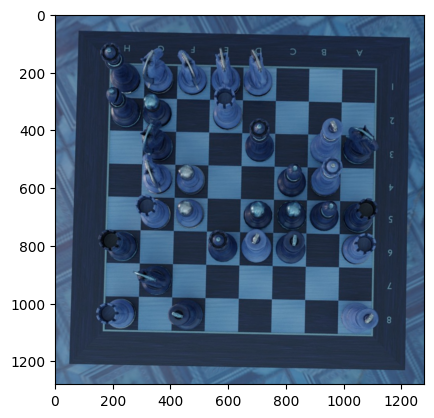

In [341]:
localize_top_chessboard_prob(read_image('../datasets/dataset 1/data/0.jpg'), corner_setup=40)

Angles found: [98.17354, 77.34031, 82.39085, 102.095276]
Differences between bases: 264.88776
-----------------------------
Slopes: [-286.03082, -331.81213]
Angles found: [110.42952, 69.37185, 73.95755, 106.24104]
updated to the last corners found
Loops: 2
Distances between adjacent points [  91.533356  270.7303   -287.7948  ]
Crop because of distances: True
Differences between distances: [492.0, 553.0, 854.0, 539.0]
Crop because of points too close: False
warp


{'img': array([[[ 65,  65,  65],
         [ 65,  65,  65],
         [ 64,  64,  64],
         ...,
         [ 62,  64,  61],
         [ 69,  69,  63],
         [ 71,  69,  67]],
 
        [[ 62,  64,  61],
         [ 63,  64,  63],
         [ 65,  65,  65],
         ...,
         [ 64,  64,  64],
         [ 66,  64,  66],
         [ 72,  71,  64]],
 
        [[ 64,  64,  63],
         [ 62,  64,  64],
         [ 63,  64,  64],
         ...,
         [ 64,  64,  64],
         [ 64,  62,  64],
         [ 65,  66,  63]],
 
        ...,
 
        [[ 33,  53,  60],
         [ 32,  52,  62],
         [ 36,  56,  66],
         ...,
         [ 46,  73, 106],
         [ 58,  87, 120],
         [ 70, 105, 132]],
 
        [[ 36,  53,  60],
         [ 37,  57,  66],
         [ 37,  55,  64],
         ...,
         [ 50,  75, 108],
         [ 65,  93, 124],
         [ 82, 115, 140]],
 
        [[ 42,  54,  62],
         [ 38,  57,  66],
         [ 35,  56,  64],
         ...,
         [ 50,  77, 1

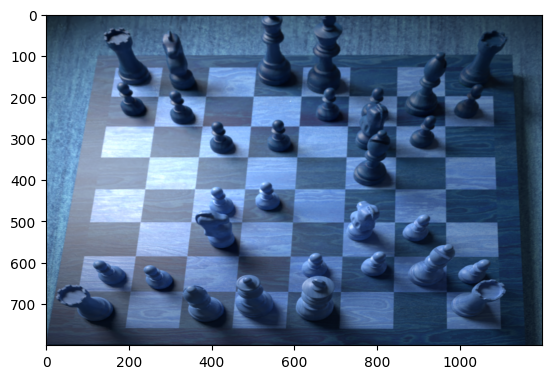

In [342]:
def check_diff_slope(corners):
    corner_copy = corners['list'].copy()
    first_slope = corner_copy[1][1] - corner_copy[0][1] / corner_copy[1][0] - corner_copy[0][0]
    # first_slope = abs(first_slope[1] / first_slope[0])
    second_slope = corner_copy[3][1] - corner_copy[2][1] / corner_copy[3][0] - corner_copy[2][0]
    # second_slope = abs(second_slope[1] / second_slope[0])
    print("Slopes:", [first_slope, second_slope])
    return False if abs(first_slope - second_slope) < 225 else True

# checking if the base angles are proper for a trapezoid
def check_trapezoid_angles(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_copy.append(corner_copy[1])
    angles = []
    for index in range(2, len(corner_copy)):
        A = np.array(corner_copy[index - 2])
        B = np.array(corner_copy[index - 1])
        C = np.array(corner_copy[index])
        dot_BA_BC = np.dot(A - B, C - B)
        angle = np.degrees(np.arccos(dot_BA_BC / (np.linalg.norm(A - B) * np.linalg.norm(C - B))))
        angles.append(angle)
    bottom_angles = np.array(angles[1:3])
    top_angles = np.array([angles[0], angles[3]])
    print("Angles found:", angles)
    return bottom_angles, top_angles
    # return False, bottom_sum if np.all(top_angles >= 90) and np.all(bottom_angles <= 90) else True, bottom_sum

# checking if the north and south lines can form a trapezoid
def check_trapezoid_bases(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_diffs = np.diff(corner_copy, axis=0)
    distances = np.sqrt(np.sum(corner_diffs**2, axis=1))
    # distances = np.append(distances, distances[0], axis=None)
    diff_base = distances[2] - distances[0]
    print("Differences between bases:", diff_base)
    return True if abs(diff_base) >= 50 else False


def localize_angled_chessboard(img, corner_setup=30):
    global corners_found
    hl_threshold = 80
    canny_low_thr = 60
    canny_high_thr = 160
    cn_boost = 0
    hlp_lower = 0
    nr_loops = 0
    ok = True

    try:
        while ok and cn_boost < 100:
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr + cn_boost)
            hough_lines = hough_line_detect_response(canny_filter, threshold=hl_threshold)
            hough_intersections = hough_line_intersections(hough_lines)
            hough_intersections['list'] = [values for values in hough_intersections['list'] if values[0] < img.shape[1] and values[1] < img.shape[0] and np.all(np.array(values) > 0)]
            corners_found = corners_on_image(hough_intersections)
            # saved_areas.append(check_corner_area(corners_found))
            # cn_boost += 10
            # hlp_lower += 10
            nr_loops += 1
            # check_trapezoid_angles(corners_found)
            # if nr_loops != 2:
            bottom_angles, top_angles = check_trapezoid_angles(corners_found)
            check_trapezoid_bases(corners_found)
            print("-----------------------------")
            if check_diff_slope(corners_found):
                print("unparallel lines")
                cn_boost += 10
                hlp_lower += 10
                ok = True
                # ok = False
            else:
                if np.sum(bottom_angles) <= 160 and np.all((60 <= bottom_angles) & (bottom_angles <= 90) & (top_angles >= 90)):
                    ok = False
                    # cn_boost += 10
                    # hlp_lower += 10
                    # ok = True
                else:
                    print("angles either above 90 or not very close")
                    cn_boost += 10
                    hlp_lower += 10
                    ok = True
                    theta_limit = 715
                    nr_loops_line = 0
                    done = False
                    while not done and nr_loops_line <= 5 :
                        hough_lines['list'] = [hough_lines['list'][index] for index in range(len(hough_lines['list'])) if hough_lines['list'][index][0] < theta_limit]
                        hough_intersections = hough_line_intersections(hough_lines)
                        hough_intersections['list'] = [values for values in hough_intersections['list'] if values[0] < 1200 and values[1] < 800 and np.all(np.array(values) > 0)]
                        corners_found = corners_on_image(hough_intersections)
                        bottom_angles, top_angles = check_trapezoid_angles(corners_found)
                        if np.all((top_angles >= 90)) and abs(np.diff(bottom_angles)) <= 10:
                            ok, done = False, True
                        else:
                            ok, done = True, False
                            theta_limit -= 20
                        nr_loops_line += 1
                    print("Finished, reached a maximum limit or tried three times to get the angles")
                    # cn_boost += 10
                    # hlp_lower += 10

        if cn_boost == 100:
            print("cannot use a larger canny threshold - we move the found points further")
            corners_found['list'][0][0] -= 50
            corners_found['list'][1][0] += 50
            corners_found['list'][2][0] += 50
            corners_found['list'][3][0] -= 50

    except:
        print("Error encountered. Image cannot be processed anymore, now detecting corners for zooming it.")

    # doing one last check to see if we are about to miss a better point arrangement - only if we haven't reached the limit for the upper canny interval
    if cn_boost != 100:
        canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr + cn_boost + 10)
        hough_lines = hough_line_detect_response(canny_filter, threshold=hl_threshold + 10)
        hough_intersections = hough_line_intersections(hough_lines)
        hough_intersections['list'] = [values for values in hough_intersections['list'] if values[0] < img.shape[1] and values[1] < img.shape[0] and np.all(np.array(values) > 0)]
        last_corners_found = corners_on_image(hough_intersections)
        last_bottom_angles, last_top_angles = check_trapezoid_angles(last_corners_found)

        if np.all(np.array(last_bottom_angles) < 80) and abs(np.diff(last_bottom_angles)) <= 5 and np.sum(last_bottom_angles) <= 160:
            print("updated to the last corners found")
            corners_found = last_corners_found
            nr_loops += 1

    # here, we verify if the distances between the detected corners are almost equal again
    # if it's true, it must be cropped, otherwise it can be warped, giving a much clearer perspective
    # in case the loop from above didn't manage to detect the corners, we will use the points that are the closest to the ends of image to zoom the board
    # print(saved_areas)
    print("Loops:", nr_loops)
    print("Crop because of distances:", check_distances(corners_found))
    print("Crop because of points too close:", check_points(corners_found))
    print("warp")
    image_op = warp_image

    # we move the found corners a bit to get all pieces fully visible
    corners_found = corners_found['list']
    corners_spaced = [[corners_found[0][0] - corner_setup, corners_found[0][1] - corner_setup], [corners_found[1][0] + corner_setup, corners_found[1][1] - corner_setup], corners_found[2], corners_found[3]]
    calibration = image_op(img, corners_spaced)

    localization_result = {
        'img' : img,
        'calibration': calibration,
        'corners' : corners_found,
        'process': image_op
    }
    return localization_result

filename_2 = "../datasets/dataset 2/train/0016.png"
localize_angled_chessboard(read_image(filename_2), corner_setup=50)

Angles found: [103.58759269654314, 73.55851354976305, 72.7937442999701, 110.06014945372371]
Slopes: [-195.2423873325213, -277.4117647058823]
Angles found: [103.58759269654314, 72.00949238485646, 72.74107283891074, 111.66184207968966]
updated to the last corners found
Angles found: [103.58759269654314, 72.00949238485646, 72.74107283891074, 111.66184207968966]
Differences between bases: 349.0638663569262
Loops: 2
Distances between adjacent points [ 105.46305569  243.60081067 -285.74280073]
Crop because of distances: True
Differences between distances: [490, 560, 842, 540]
Crop because of points too close: False
warp


{'img': array([[[ 66,  67,  67],
         [ 66,  65,  65],
         [ 64,  64,  63],
         ...,
         [ 61,  63,  60],
         [ 66,  66,  60],
         [ 69,  67,  64]],
 
        [[ 61,  64,  60],
         [ 62,  63,  62],
         [ 64,  65,  64],
         ...,
         [ 63,  64,  63],
         [ 65,  64,  65],
         [ 70,  69,  63]],
 
        [[ 64,  63,  62],
         [ 61,  62,  63],
         [ 63,  64,  64],
         ...,
         [ 64,  64,  65],
         [ 64,  62,  64],
         [ 64,  65,  62]],
 
        ...,
 
        [[ 44,  67,  87],
         [ 49,  74,  97],
         [ 49,  75,  96],
         ...,
         [ 40,  63,  85],
         [ 39,  58,  80],
         [ 41,  61,  81]],
 
        [[ 40,  63,  83],
         [ 48,  76, 100],
         [ 51,  74,  98],
         ...,
         [ 40,  62,  84],
         [ 38,  58,  78],
         [ 47,  67,  86]],
 
        [[ 49,  66,  85],
         [ 42,  64,  86],
         [ 45,  68,  90],
         ...,
         [ 37,  61,  

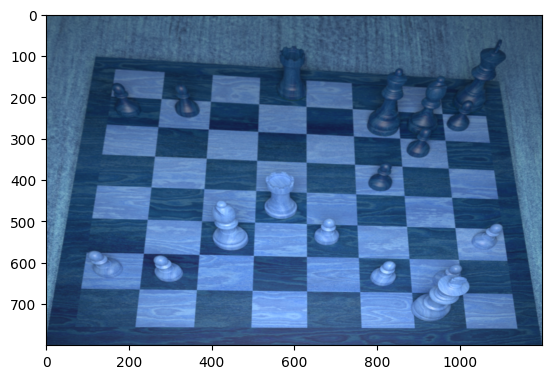

In [343]:
# checking if the base angles are proper for a trapezoid
def check_trapezoid_angles(corners):
    corner_copy = corners['list'].copy()
    corner_copy.append(corner_copy[0])
    corner_copy.append(corner_copy[1])
    angles = []
    for index in range(2, len(corner_copy)):
        A = np.array(corner_copy[index - 2])
        B = np.array(corner_copy[index - 1])
        C = np.array(corner_copy[index])
        dot_BA_BC = np.dot(A - B, C - B)
        angle = np.degrees(np.arccos(dot_BA_BC / (np.linalg.norm(A - B) * np.linalg.norm(C - B))))
        angles.append(angle)
    bottom_angles = np.array(angles[1:3])
    top_angles = np.array([angles[0], angles[3]])
    print("Angles found:", angles)
    return bottom_angles, top_angles

# check if the difference between the slopes of the upper and lower borders is right for detection
def check_diff_slope(corners):
    corner_copy = corners['list'].copy()
    first_slope = corner_copy[1][1] - corner_copy[0][1] / corner_copy[1][0] - corner_copy[0][0]
    second_slope = corner_copy[3][1] - corner_copy[2][1] / corner_copy[3][0] - corner_copy[2][0]
    print("Slopes:", [first_slope, second_slope])
    return False if abs(first_slope - second_slope) < 200 else True

def localize_angled_chessboard_prob(img, corner_setup=40):
    global corners_found
    canny_low_thr = 70
    canny_high_thr = 160
    hlp_threshold = 90
    minLineLength = 100
    maxLineGap = 150
    cn_boost = 0
    nr_loops = 0
    nr_tries = 5
    ok = True

    try:
        while ok:
            canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr + cn_boost)
            houghp_lines = houghp_line_detect_response(canny_filter, threshold=hlp_threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
            # for values in houghp_lines['list']:
            #     if np.any(np.array(values) > img.shape[0]) or np.any(np.array(values) > img.shape[1]) or np.any(np.array(values) < 0):
            #         houghp_lines['list'].remove(values)
            houghp_points = houghp_line_points(houghp_lines)
            corners_found = corners_on_image(houghp_points)
            bottom_angles, top_angles = check_trapezoid_angles(corners_found)
            nr_loops += 1
            # cn_boost += 10
            # if nr_loops != 1:
            if check_diff_slope(corners_found):
                print("unparallel lines")
                cn_boost += 10
                ok = True
            else:
                if np.all(np.array(bottom_angles) < 80) and abs(np.diff(bottom_angles)) <= 5 and np.sum(bottom_angles) <= 160:
                    ok = False
                else:
                    print("angles either above 80 or not very close")
                    nr_tries -= 1
                    cn_boost += 10
                    ok = True
                    if nr_tries == 0:
                        print("changing threshold doesn't work - we move the points further")
                        corner_copy = corners_found['list'].copy()
                        corner_copy[0][0] -= 100
                        corner_copy[1][0] += 100
                        corner_copy[2][0] += 100
                        corner_copy[3][0] -= 100
                        ok = False
    except:
        print("Error encountered. Image cannot be processed anymore, now detecting corners for zooming it.")
        nr_loops = 20

    # doing one last check to see if we are about to miss a better point arrangement
    canny_filter = canny_edge_response(img, low_thr=canny_low_thr, high_thr=canny_high_thr + cn_boost + 10)
    houghp_lines = houghp_line_detect_response(canny_filter, threshold=hlp_threshold, minLineLength=minLineLength, maxLineGap=maxLineGap)
    houghp_lines = houghp_line_points(houghp_lines)
    last_corners_found = corners_on_image(houghp_lines)
    last_bottom_angles, last_top_angles = check_trapezoid_angles(last_corners_found)

    if np.all(np.array(last_bottom_angles) < 80) and abs(np.diff(last_bottom_angles)) <= 5 and np.sum(last_bottom_angles) <= 160 and np.all(bottom_angles > last_bottom_angles):
        print("updated to the last corners found")
        corners_found = last_corners_found
        nr_loops += 1

    plt.imshow(corners_found['img'])
    check_trapezoid_angles(corners_found)
    check_trapezoid_bases(corners_found)
    print("Loops:", nr_loops)
    print("Crop because of distances:", check_distances(corners_found))
    print("Crop because of points too close:", check_points(corners_found))

    print("warp")
    image_op = warp_image

    # we move the found corners a bit to get all pieces fully visible
    corners_found = corners_found['list']
    corners_spaced = [[corners_found[0][0] - corner_setup, corners_found[0][1] - corner_setup], [corners_found[1][0] + corner_setup, corners_found[1][1] - corner_setup], corners_found[2], corners_found[3]]
    calibration = image_op(img, corners_spaced)

    localization_result = {
        'img' : img,
        'calibration': calibration,
        'corners' : corners_found,
        'process': image_op
    }
    return localization_result

filename_2 = "../datasets/dataset 2/train/0040.png"
localize_angled_chessboard_prob(read_image(filename_2), corner_setup=50)